# Explore bottlenecked iterative FACS results

In [1]:
from datetime import date
print('created 2024-05-21')
print("last updated", date.today())

created 2024-05-21
last updated 2025-01-23


In [2]:
# imports

import sys
import pickle
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from scipy import stats
from scipy.stats import spearmanr
from Levenshtein import distance as lev

sys.path.append("/Users/emmakowal/Dropbox (MIT)/Lab/Cluster/IME/scripts")
from functions import *
from constants import *

# aesthetics

%matplotlib inline
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'regular'
plt.rcParams['figure.dpi']= 200

sns.set_palette("husl", 5)
def nicecolors(n, m=5):
    return sns.color_palette("husl", m)[n]

In [3]:
# path to i/o:
outpath = '/Users/emmakowal/Dropbox (MIT)/Lab/Notebooks/docs/'
IME_path = outpath+'../../Cluster/IME/'
RIL2_path = IME_path+'RIL2/'

# load in barcode-to-intron dictionary
with open(outpath+'pkls/b2i_06_with_spikeins_and_flanking_seq_min3readclusters_10trustworthy.pkl', 'rb') as f:
    b2i = pickle.load(f)

# iterative FACS reads
with open(RIL2_path+'element/RIL2_b2rc.pkl', 'rb') as f:
    RIL2 = pickle.load(f)

In [72]:
# load in data from the 2 screens + DESeq2 output
# this table contains only trusted barcodes (≤10% mismatches)
# and only barcodes passing 3 sample filter (≥10 GFP + ≥10 dTom reads)

with open(outpath+"pkls/RIL12only_b2i06min3readclusters_10percentMM_4sampfilter_DESeq2_output.pkl", 'rb') as f:
    df = pickle.load(f)

num_reps = 10
RNA_seq_bcs = list(df.index)
l2fc = df.PosteriorMean
l2fc_SD = df.PosteriorSD

GFP_counts = df.values[:,:num_reps]    # DOES NOT include unspliced
dTom_counts = df.values[:,num_reps:num_reps*2]
unspliced_GFP_counts = df.values[:,num_reps*2:num_reps*3]
readcounts = GFP_counts + unspliced_GFP_counts + dTom_counts

intronless_barcodes = ['ACTATCTAACCAAACACA', 
                       'ACTCCTTCAATCCCATCA',
                       'CATAACTTAATTATTTTA',
                       'TACATTATCTCTTCATAC']
UbC_bc = 'ATACCATAACTACCCACT'
spike_in_bcs = intronless_barcodes+[UbC_bc]

intless_mask = [b in intronless_barcodes for b in RNA_seq_bcs]
pos_ctrl_mask = [b==UbC_bc for b in RNA_seq_bcs]

i_msk = np.array(intless_mask)
intless_baseline = l2fc[i_msk].mean()
norm_l2fc = np.array(l2fc-intless_baseline)

p_cutoff = 0.05
sig = df['padj'].values<p_cutoff
pos = df['PosteriorMean'].values>1
neg = df['PosteriorMean'].values<-1

significant = sig & (pos|neg)
non_significant = ~significant

up_bcs = [b for b in df[sig&pos].index]
down_bcs = [b for b in df[sig&neg].index]

# Explore FACS signal of different bins and controls vs library

In [5]:
import fcsparser

# function to read fcs data
def fcs_to_list(path):
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    return list(data['FITC-A'])

# function to read FITC and PE
def fcs_to_list_with_dTom(path):
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    return list(data['FITC-A']), list(data['PE-A'])

def fcs_to_list_dTom_only(path):
    meta, data = fcsparser.parse(path, meta_data_only=False, reformat_meta=True)
    return list(data['PE-A'])

In [6]:
# import data from .fcs files for each sample, store as dict
FACS_RIL_vs_intless = {}
samples = ['negative','pEK20','pEK21','pEK23','RILwc']

for sample in samples:
    samppath = outpath+f'data/FACS/HEK_{sample}.fcs'
    FACS_RIL_vs_intless[sample] = list(fcs_to_list_with_dTom(samppath))

# create dTom+ filtered RIL
samples.append('RIL_dTom+')
RIL_arr = np.array(FACS_RIL_vs_intless['RILwc'])
filtered = RIL_arr[:, (RIL_arr[1, :] > 400)]
FACS_RIL_vs_intless['RIL_dTom+'] = [list(filtered[0,:]),list(filtered[1,:])]

# filter extreme values
#for sample in samples:
#    sample_arr = np.array(FACS_RIL_vs_intless[sample])
#    filtered = sample_arr[:,(sample_arr[0, :] > 5)&(sample_arr[1, :] > 5)&(sample_arr[1, :] < 50000)]
#    FACS_RIL_vs_intless[sample] = [list(filtered[0,:]),list(filtered[1,:])]
    
# truncate to make all same length
#s_lens = [len(FACS_RIL_vs_intless[sample][0]) for sample in samples]
#for sample in samples:
#    for i in [0,1]:
#        FACS_RIL_vs_intless[sample][i] = FACS_RIL_vs_intless[sample][i][:min(s_lens)]

# convert dict to df, store as .csv
csv_df = pd.DataFrame.from_dict(FACS_RIL_vs_intless, orient='index')
csv_df.columns = ['GFP','dTomato']
csv_df.to_csv(outpath+'data/FACS/FACS_RIL_exps_oct_2019.csv', index=False)

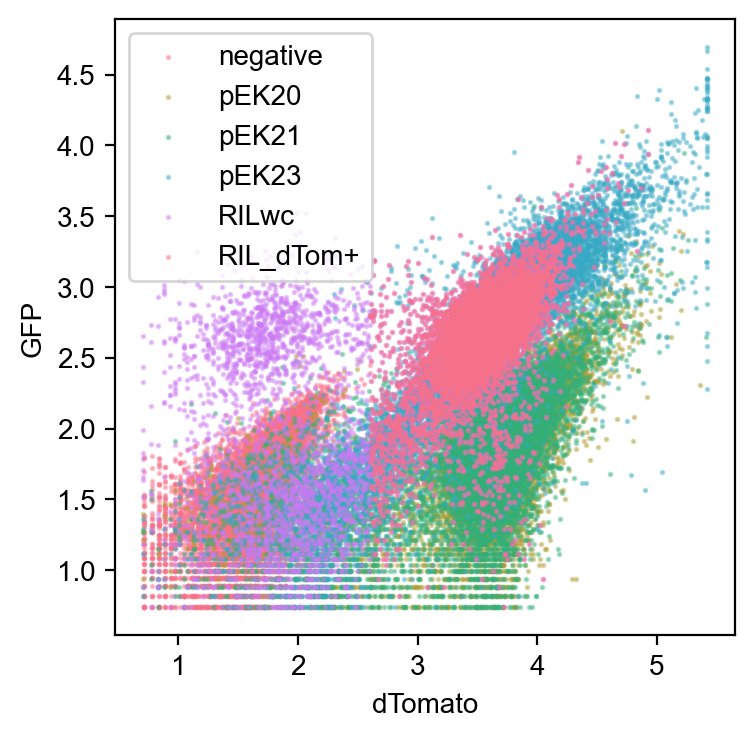

In [7]:
# plot raw values, filtering out extremes

plt.figure(figsize=(4,4))

for sample in samples:
    xdata = np.array(csv_df.loc[sample, 'dTomato'])
    ydata = np.array(csv_df.loc[sample, 'GFP'])
    mask = (xdata>5)&(ydata>5)&(ydata<50000)
    plt.scatter(np.log10(xdata[mask]), np.log10(ydata[mask]), 
                s=1, alpha=0.4,
               label=sample)
    
plt.xlabel('dTomato')
plt.ylabel('GFP')

#plt.xlim(0,20000)
#plt.ylim(0,4000)
plt.legend()
plt.show()

In [9]:
# What is the median GFP/dTom fluorescence ratio for each sample
# after subtracting autofluorescence?

# Calculate the median fluorescence for the negative control
baselines = [np.median(x) for x in csv_df.loc['negative'][:2]]

# Normalize the data by subtracting the median parental cell fluorescence
norm_df = csv_df.copy()
norm_df['GFP'] = [(np.array(x-baselines[0])) for x in csv_df.GFP]
norm_df['dTomato'] = [(np.array(x-baselines[1])) for x in csv_df.dTomato]

In [10]:
def get_data_to_plot(df, samples):
    df['Sample'] = df.index
    melted_df = csv_df.explode(['GFP', 'dTomato'])
    
    data2plot = {s:[] for s in samples}
    for sample in samples:
        sample_data = melted_df[melted_df['Sample'] == sample]
        mask = (sample_data['GFP']>1)&(sample_data['dTomato']>1)
        data2plot[sample] = [[np.log10(x) for x in sample_data[mask]['dTomato']], [np.log10(x) for x in sample_data[mask]['GFP']]] 
    return data2plot

data2plot = get_data_to_plot(csv_df, samples)
normdata2plot = get_data_to_plot(norm_df, samples)

### make contour plots

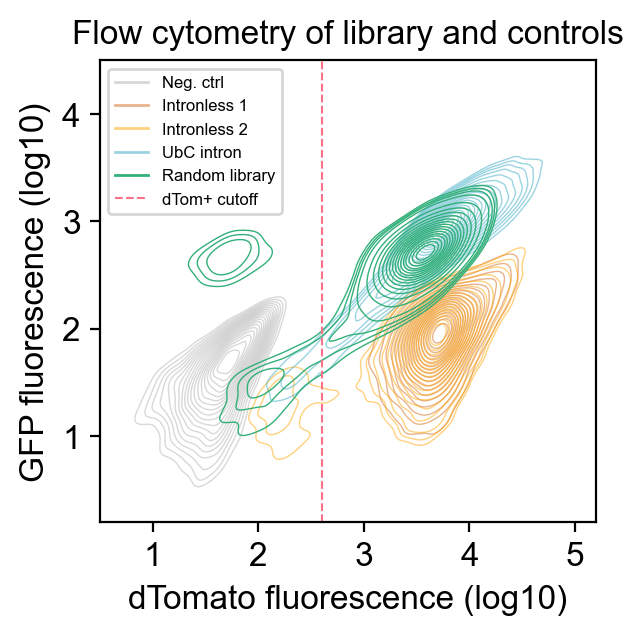

In [14]:
contour_colors = ['grey','chocolate','orange',nicecolors(3),nicecolors(2),'green']
contour_labels = ['Neg. ctrl','Intronless 1','Intronless 2','UbC intron','Random library','Random library dTom+']
contour_alphas = [0.3, 0.5, 0.5, 0.5, 1., 1.]

plt.figure(figsize=(3.2,3))

for i,sample in enumerate(samples[:-1]):
    #kwargs={'linewidth':0.1}
    kde = sns.kdeplot(x=data2plot[sample][0],#[:1000],
                      y=data2plot[sample][1],#[:1000],
                      levels=20, bw_adjust=0.8, 
                      thresh=0.2, 
                      color=contour_colors[i],
                      alpha=contour_alphas[i]
                       )
    
    for line in kde.collections:
        line.set_linewidth(0.5)
        
    plt.plot(0,0, linewidth=1, c=contour_colors[i], 
             label=contour_labels[i], alpha=contour_alphas[i])
    
plt.title('Flow cytometry of library and controls', fontsize=12)
plt.ylabel('GFP fluorescence (log10)', fontsize=12)
plt.xlabel('dTomato fluorescence (log10)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axvline(np.log10(400), linestyle='--', linewidth=0.75, label='dTom+ cutoff')
plt.legend(fontsize=6, loc='upper left')
plt.ylim(0.2,4.5)
plt.xlim(0.5,5.2)

plt.savefig('figures/Fig5C.png', dpi=900, bbox_inches='tight')

plt.show()

In [15]:
def safe_divide(gfp, dtomato):
    return gfp / dtomato if dtomato != 0 else np.nan

melted = norm_df.explode(['GFP', 'dTomato'])
melted['log_ratio'] = np.log2([safe_divide(x,y) for x,y in zip(melted['GFP'],melted['dTomato'])])
melted = melted.dropna()

/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_27645/2613589509.py:5: RuntimeWarning: divide by zero encountered in log2
  melted['log_ratio'] = np.log2([safe_divide(x,y) for x,y in zip(melted['GFP'],melted['dTomato'])])
/var/folders/q5/vnz9dxbd47dfym4t1ss4cfhc0000gn/T/ipykernel_27645/2613589509.py:5: RuntimeWarning: invalid value encountered in log2
  melted['log_ratio'] = np.log2([safe_divide(x,y) for x,y in zip(melted['GFP'],melted['dTomato'])])


In [16]:
print('median log2 ratio GFP/dTom fluorescence:')
for sample in samples[1:]:
    IME = np.median(melted.log_ratio[melted.Sample==sample])
    print(f'{sample}: {IME:.4f}')

intronless_ratios = [np.median(melted.log_ratio[melted.Sample==sample]) for sample in ['pEK20','pEK21']]
intless_log_ratio = np.mean(intronless_ratios)
melted['intless_norm_ratio'] = melted['log_ratio'] - intless_log_ratio

print('\nnormalized to intronless:')
for sample in samples:
    IME = np.median(melted.intless_norm_ratio[melted.Sample==sample])
    IME_mean = np.mean(melted.intless_norm_ratio[melted.Sample==sample])
    CI_high = np.percentile(melted.intless_norm_ratio[melted.Sample==sample], 97.5)
    CI_low = np.percentile(melted.intless_norm_ratio[melted.Sample==sample], 2.5)
    #print(f'{sample}: median {2**IME:.2f}, mean {2**IME_mean:.2f}, 2SD around mean = ({low:.2f} - {upp:.2f})')
    print(f'{sample}: median {2**IME:.2f}, 95%CI = ({2**CI_low:.2f} - {2**CI_high:.2f})')

median log2 ratio GFP/dTom fluorescence:
pEK20: -6.1408
pEK21: -6.0670
pEK23: -2.9224
RILwc: -2.8271
RIL_dTom+: -2.9453

normalized to intronless:
negative: median 74.84, 95%CI = (2.75 - 835.74)
pEK20: median 0.97, 95%CI = (0.10 - 30.99)
pEK21: median 1.03, 95%CI = (0.11 - 63.70)
pEK23: median 9.07, 95%CI = (1.78 - 43.74)
RILwc: median 9.69, 95%CI = (1.69 - 1223.94)
RIL_dTom+: median 8.93, 95%CI = (1.73 - 25.20)


In [17]:
mean_IME = np.mean(melted.intless_norm_ratio[melted.Sample=='RIL_dTom+'])

In [18]:
IME_std = np.std(melted.intless_norm_ratio[melted.Sample=='RIL_dTom+'])

In [20]:
i_msk = np.array(intless_mask)
intless_log_mean = l2fc[i_msk].mean()
intless_log_SD = np.std(l2fc[i_msk])

intless_nat_mean = 2**intless_log_mean
intless_nat_upper_bound = 2**(intless_log_mean+intless_log_SD)
intless_nat_lower_bound = 2**(intless_log_mean-intless_log_SD)

lib_log_mean = np.mean(norm_l2fc[~i_msk])
lib_log_SD = np.std(norm_l2fc[~i_msk])

lib_nat_mean = 2**lib_log_mean
lib_nat_upper_bound = 2**(lib_log_mean+lib_log_SD)
lib_nat_lower_bound = 2**(lib_log_mean-lib_log_SD)

print(f'The estimated effect of an intronless barcode')
print(f'is to decrease GFP expresion to {intless_nat_mean:.2f}X ({intless_nat_lower_bound:.2f} - {intless_nat_upper_bound:.2f}) compared to the mean of the library,')

mean_original, std_original = (2**np.mean(norm_l2fc[~i_msk]), 2**np.std(norm_l2fc[~i_msk]))
print(f'\nIn other words, compared to an intronless GFP,')
print(f'the average intron in the library increases GFP expression {lib_nat_mean:.1f}X ({lib_nat_lower_bound:.1f} - {lib_nat_upper_bound:.1f}).')

The estimated effect of an intronless barcode
is to decrease GFP expresion to 0.12X (0.04 - 0.38) compared to the mean of the library,

In other words, compared to an intronless GFP,
the average intron in the library increases GFP expression 8.5X (6.9 - 10.6).


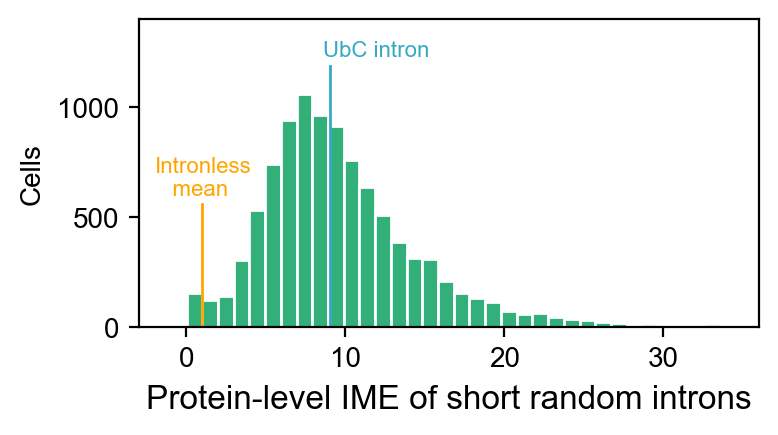

In [21]:
plt.figure(figsize=(4,2))
plt.hist([2**x for x in melted.intless_norm_ratio[melted.Sample=='RIL_dTom+'] if 2**x<40], bins=40, #density=True,
         edgecolor='w', facecolor=nicecolors(2))
plt.xlabel('Protein-level IME of short random introns', fontsize=12)
plt.ylabel('Cells')
#marks = [1, 2.5, 5, 7.5, 10, 12.5, 15]
#plt.xticks((marks),[str(x) for x in marks])

UbC_fc = 2**(np.median(melted.intless_norm_ratio[melted.Sample=='pEK23']))
plt.axvline(UbC_fc, c=nicecolors(3), ymin=0, ymax=0.85, linewidth=1)
plt.annotate('UbC intron',xy=(UbC_fc-0.5,1230), fontsize=8, c=nicecolors(3))

plt.axvline(1, c='orange', ymin=0, ymax=0.4, linewidth=1)
plt.annotate('Intronless\n   mean',xy=(-2,600), fontsize=8, c='orange')

plt.ylim(0, 1400)
plt.xlim(-3,36)

plt.show()

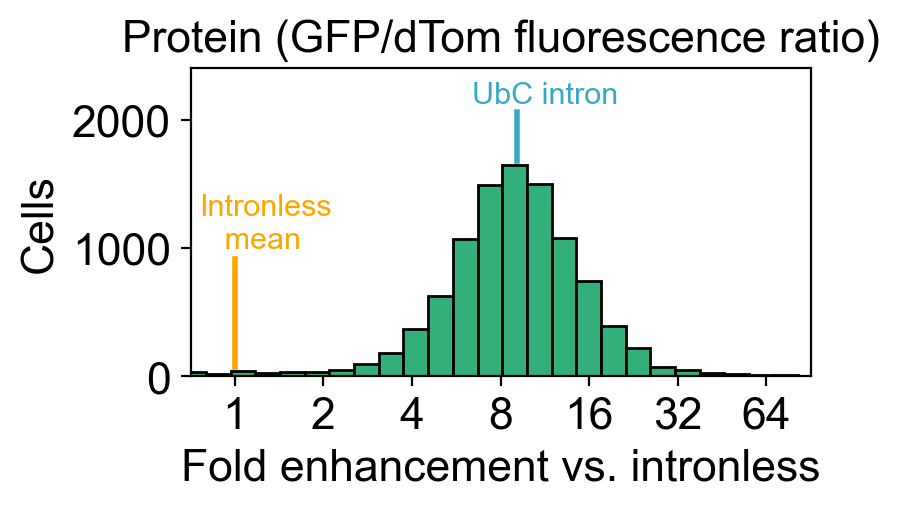

In [39]:
plt.figure(figsize=(4,2))
plt.hist([x for x in melted.intless_norm_ratio[melted.Sample=='RIL_dTom+']], bins=50, #density=True,
         edgecolor='k', facecolor=nicecolors(2))
plt.xlabel('Fold enhancement vs. intronless', fontsize=16)
plt.ylabel('Cells',fontsize=16)

marks = np.array([1, 2, 4, 8, 16, 32, 64])
plt.xticks(np.log2(marks),[str(x) for x in marks], fontsize=16)
plt.yticks([0,1000,2000], fontsize=16)

UbC_fc = (np.median(melted.intless_norm_ratio[melted.Sample=='pEK23']))
plt.axvline(UbC_fc, c=nicecolors(3), ymin=0.7, ymax=0.86, linewidth=2)
plt.annotate('UbC intron',xy=(UbC_fc-0.5,2130), fontsize=11, c=nicecolors(3))

plt.axvline(0, c='orange', ymin=0.03, ymax=0.38, linewidth=2)
plt.annotate('Intronless\n   mean',xy=(-0.4,1000), fontsize=11, c='orange')

plt.ylim(0, 2400)
plt.xlim(-0.5,6.5)

plt.title('Protein (GFP/dTom fluorescence ratio)', fontsize=16)

plt.savefig('figures/Fig5D2.png', dpi=900, bbox_inches='tight')

plt.show()

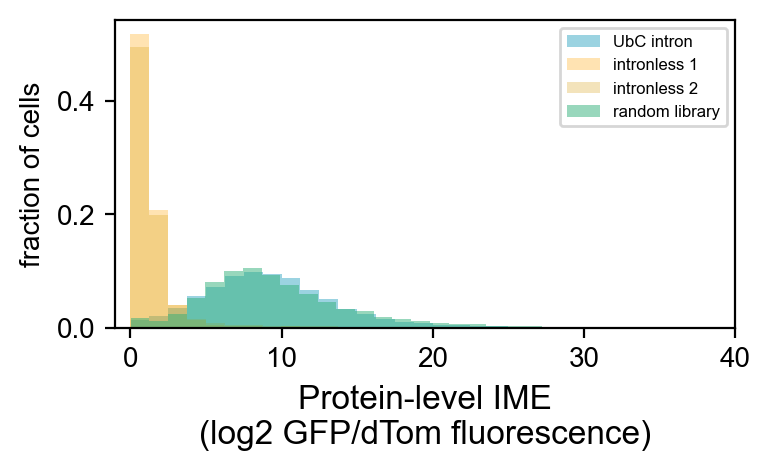

In [23]:
plt.figure(figsize=(4,2))

plt.hist([2**x for x in melted.intless_norm_ratio[melted.Sample=='pEK23'] if 2**x<50], bins=40, density=True,
         #edgecolor='w', 
         facecolor=nicecolors(3), alpha=0.5, label='UbC intron')

plt.hist([2**x for x in melted.intless_norm_ratio[melted.Sample=='pEK20']if 2**x<50], bins=40,  density=True,
         #edgecolor='w', 
         facecolor='orange', alpha=0.3, label='intronless 1')

plt.hist([2**x for x in melted.intless_norm_ratio[melted.Sample=='pEK21']if 2**x<50], bins=40,  density=True,
         #edgecolor='w', 
         facecolor='goldenrod', alpha=0.3, label='intronless 2')

plt.hist([2**x for x in melted.intless_norm_ratio[melted.Sample=='RIL_dTom+']if 2**x<50], bins=40,  density=True,
         #edgecolor='w', 
         facecolor=nicecolors(2), alpha=0.5, label='random library')


plt.xlabel('Protein-level IME\n(log2 GFP/dTom fluorescence)', fontsize=12)
plt.ylabel('fraction of cells')
#plt.ylim(0, 1050)
plt.xlim(-1,40)
plt.legend(fontsize=6, loc='upper right')
plt.show()

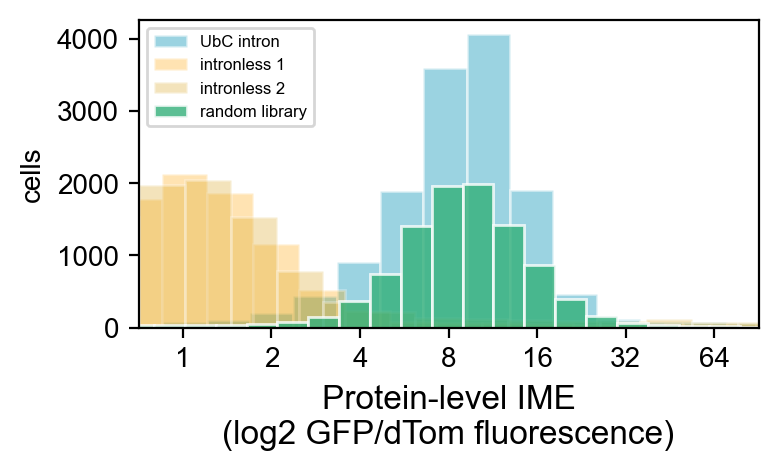

In [24]:
plt.figure(figsize=(4,2))

plt.hist([x for x in melted.intless_norm_ratio[melted.Sample=='pEK23']], bins=40, 
         edgecolor='w', facecolor=nicecolors(3), alpha=0.5, label='UbC intron')

plt.hist([x for x in melted.intless_norm_ratio[melted.Sample=='pEK20']], bins=40, 
         edgecolor='w', facecolor='orange', alpha=0.3, label='intronless 1')

plt.hist([x for x in melted.intless_norm_ratio[melted.Sample=='pEK21']], bins=40, 
         edgecolor='w', facecolor='goldenrod', alpha=0.3, label='intronless 2')

plt.hist([x for x in melted.intless_norm_ratio[melted.Sample=='RIL_dTom+']], bins=40, 
         edgecolor='w', facecolor=nicecolors(2), alpha=0.8, label='random library')

marks = np.array([1, 2, 4, 8, 16, 32, 64])
plt.xticks(np.log2(marks),[str(x) for x in marks])

plt.xlabel('Protein-level IME\n(log2 GFP/dTom fluorescence)', fontsize=12)
plt.ylabel('cells')
#plt.ylim(0, 2400)
plt.xlim(-0.5,6.5)
plt.legend(fontsize=6, loc='upper left')
plt.show()

# Explore sets of introns detected in each bin

In [75]:
# get sets of introns detected in each rep with at least n reads of any type

# sample names
iFACS_sample_names = ['G1_1','G2_1','G3_1',
                      'R1_1','R2_1','R3_1',
                      'G1_2','G2_2','G3_2',
                      'R1_2','R2_2','R3_2']
iFACS_reps = np.arange(7,19)
iFACS_reps_plot_order = [9,8,7,
                        10,11,12,
                        15,14,13,
                        16,17,18]

def get_insets_with_n_reads(cutoff):
    intsets = {i:{} for i in iFACS_sample_names}
    for r in iFACS_reps:
        intsets[iFACS_sample_names[r-7]] = set([x for x in RIL2 if np.sum([RIL2[x][r][n] for n in [0,1,2]])>=cutoff])
    return intsets

intsets_with_n_reads = {}
for n in [1,10,100,1000]:
    intsets_with_n_reads[n] = get_insets_with_n_reads(n)

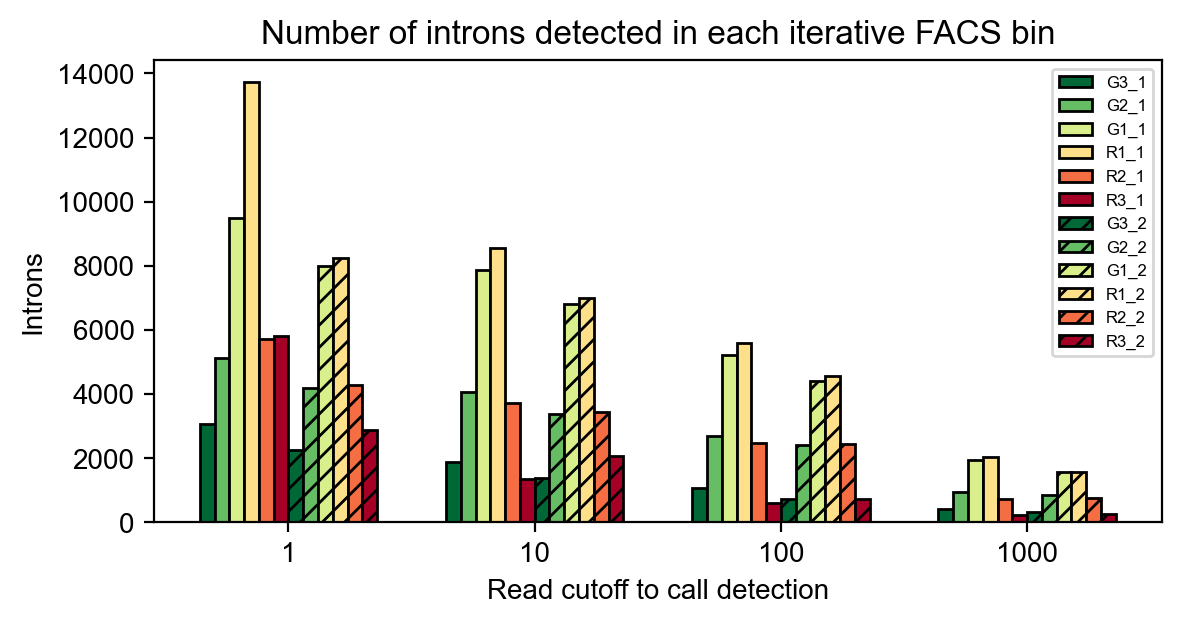

In [76]:
cmap = plt.get_cmap('RdYlGn_r', 6)

# Create a bar plot
fig, ax = plt.subplots(figsize=(6.5,3))

bar_width = 0.06
bar_positions = np.arange(len(intsets_with_n_reads))

# Iterate through names and integers
for i in range(len(iFACS_reps)):
    j = iFACS_reps_plot_order[i]
    name = iFACS_sample_names[(j-7)]
    set_sizes = [len(intsets_with_n_reads[cutoff][name]) for cutoff in sorted(intsets_with_n_reads.keys())]
    ax.bar(bar_positions + (i) * bar_width, 
           set_sizes, width=bar_width, facecolor=cmap((i)%6),
           edgecolor='k',linewidth=1, hatch={True:'///',False:''}['_2' in name],
           label=name, align='center')

# Customize plot appearance
ax.set_xticks(bar_positions + (len(iFACS_sample_names) - 1) * bar_width / 2)
ax.set_xticklabels(sorted(intsets_with_n_reads.keys()))

ax.set_xlabel('Read cutoff to call detection')
ax.set_ylabel('Introns')
ax.set_title('Number of introns detected in each iterative FACS bin')
ax.legend(fontsize=6)

# Show the plot
plt.show()

In [77]:
cutoff = 100
iFACS_bins = ['G3','G2','G1','R1','R2','R3']

# to combine information from both replicates
# get intersections and unions of barcodes seen in each bin
intersections = {b:0 for b in iFACS_bins}
unions = {b:0 for b in iFACS_bins}
for name in iFACS_bins:
    set1, set2 = [intsets_with_n_reads[cutoff][f'{name}_{rep}'] for rep in [1,2]]
    intersections[name] = set1&set2
    unions[name] = set1|set2

In [78]:
# define the background set as introns in either G1 or R1
# that are not found in ANY G2-3 or R2-3

round1 = unions['G1']&unions['R1']
any_selection = unions['G2']|unions['R2']|unions['G3']|unions['R3']
bg_set = round1 - any_selection
len(bg_set)

# can also use all detected bcs as background set
# here detected means at least 100 reads in ANY sample
all_FACS_bcs = set(flatten(unions.values()))

# get sets of bcs found in all 3 stages of each color
# can be in either rep or both
# exclude bcs found in any stage any rep of other color
any_red = unions['R3']|unions['R2']|unions['R1']
any_green = unions['G3']|unions['G2']|unions['G1']

all_stages_either_rep_red = unions['R3']&unions['R2']&unions['R1']
all_stages_either_rep_green = unions['G3']&unions['G2']&unions['G1']

green_bcs = all_stages_either_rep_green-any_red
red_bcs = all_stages_either_rep_red-any_green

# what about only considering stages 2 and 3 as significant?

any_top2_red = unions['R3']|unions['R2']
any_top2_green = unions['G3']|unions['G2']
both_top2_red = unions['R3']&unions['R2']
both_top2_green = unions['G3']&unions['G2']
top2_green_clean = both_top2_green - any_top2_red
top2_red_clean = both_top2_red - any_top2_green

In [79]:
#with (open(outpath+"pkls/RIL2_iFACS_selected_bc_sets.pkl",'wb')) as f:
#    pickle.dump({'g':green_bcs,'r':red_bcs,'bg':bg_set},f)

In [80]:
# reload selected sets for visualization
with open(outpath+"pkls/RIL2_iFACS_selected_bc_sets.pkl", 'rb') as f:
    iFACS_bcsets = pickle.load(f)

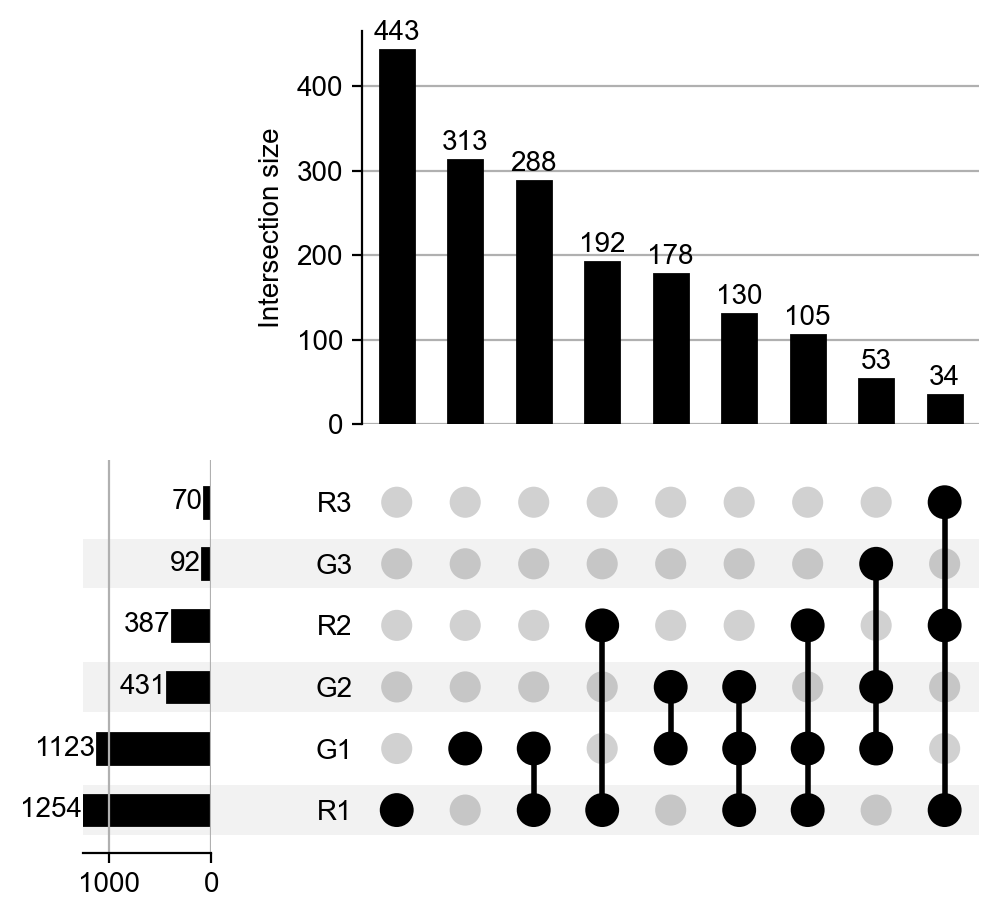

In [81]:
import upsetplot as ups

ups.plot(ups.from_contents(intersections), 
         sort_by='cardinality',
         min_subset_size=25, 
         show_counts=True)
plt.show()

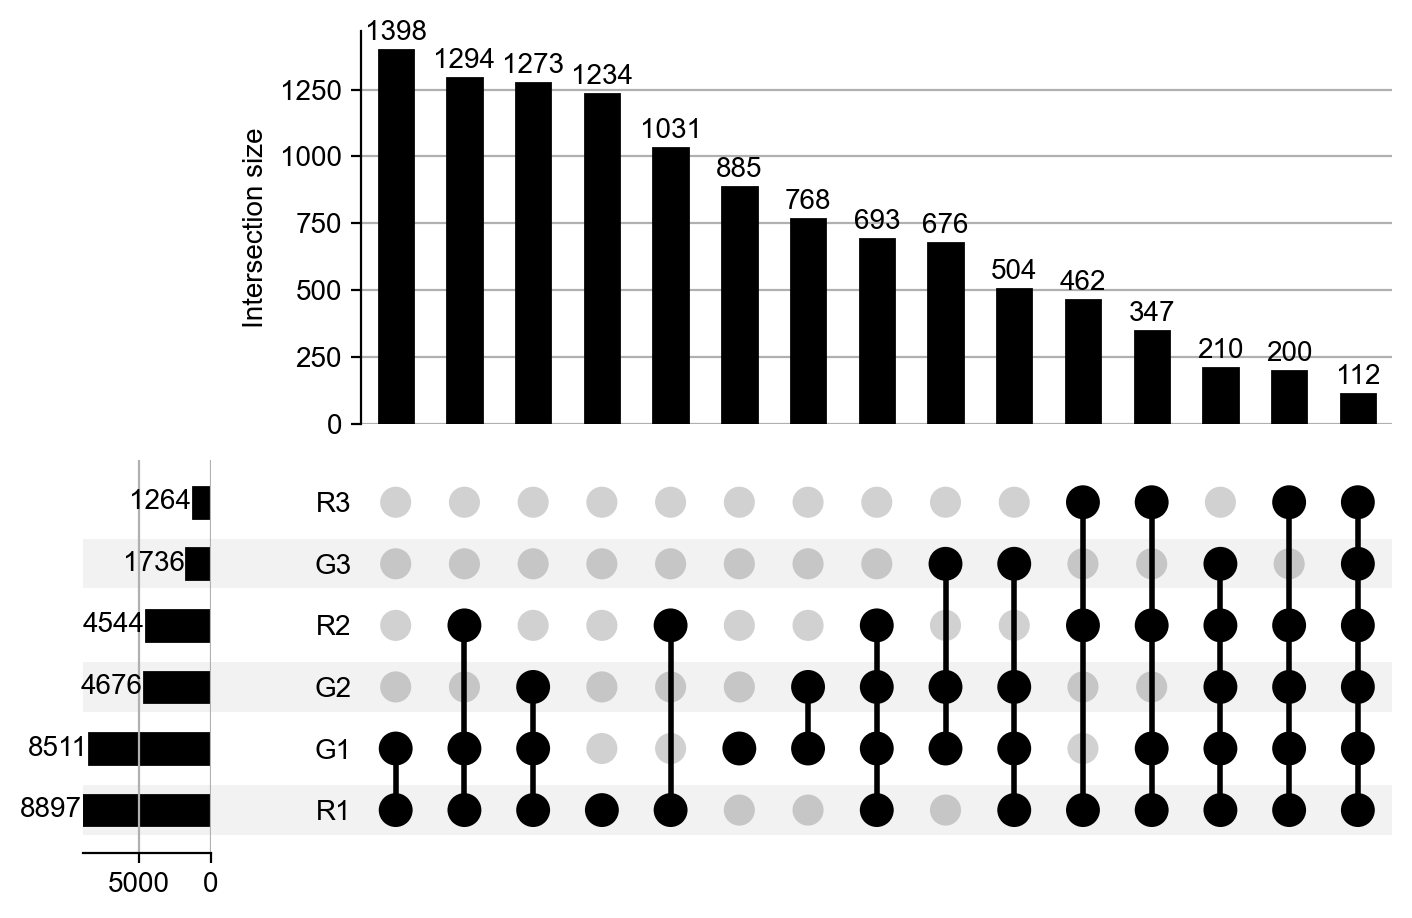

In [82]:
ups.plot(ups.from_contents(unions), 
         sort_by='cardinality',
         min_subset_size=100, 
         show_counts=True)
plt.show()

In [83]:
# plotting functions
cmap = plt.get_cmap('RdYlGn_r', 6)
cdf_range = np.median(norm_l2fc)-np.percentile(norm_l2fc,1)

def plot_cdf(ax,bcs,color,linestyle='-',label='', ylabel='ecdf'):
    bcs_mask = np.array([b in bcs for b in RNA_seq_bcs])
    ax.hist(norm_l2fc[bcs_mask],bins=2000,
             color=color, cumulative=True, histtype='step', density=True, 
             linewidth=1.5, alpha=0.8, linestyle=linestyle, label=label)
    ax.set_ylabel(ylabel)
    ax.set_xlim(np.median(norm_l2fc)-cdf_range,np.median(norm_l2fc)+cdf_range)
    ax.set_ylim(-0.05,1.05)

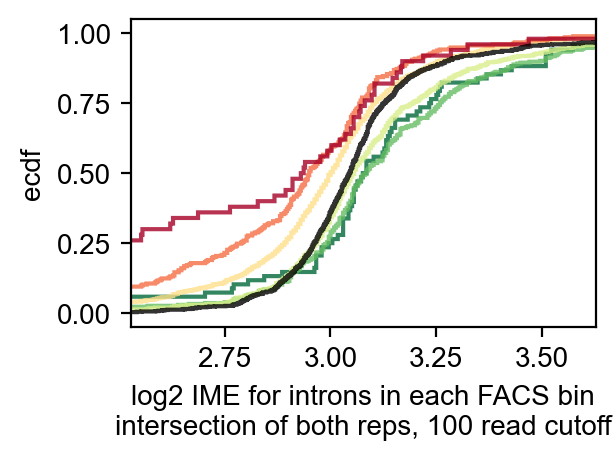

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
for i,bin in enumerate(iFACS_bins):
    plot_cdf(ax, intersections[bin], cmap(i))
plot_cdf(ax, bg_set, 'k')
ax.set_xlabel(f'log2 IME for introns in each FACS bin\nintersection of both reps, {cutoff} read cutoff')
plt.show()

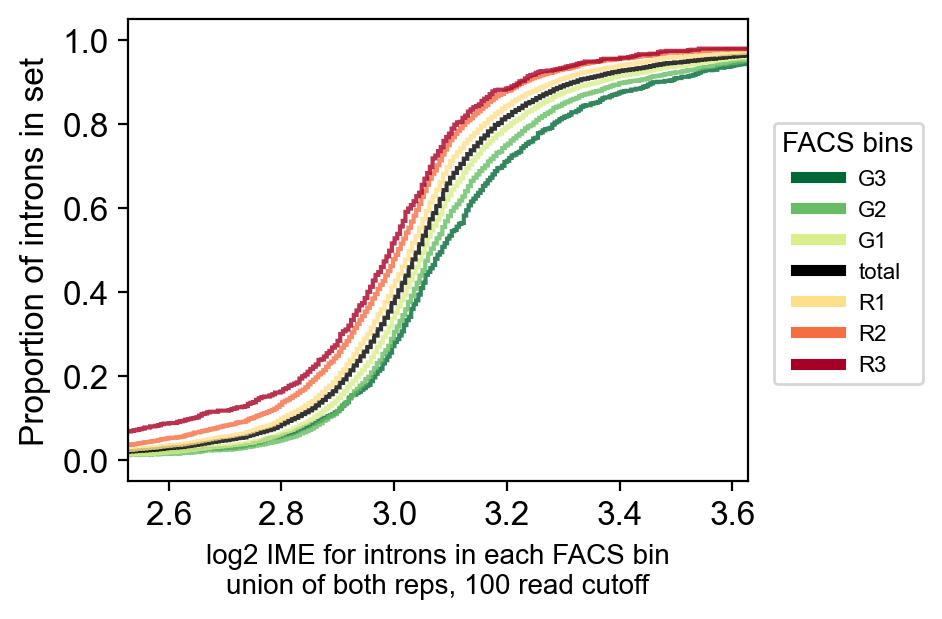

In [85]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 1, figsize=(4,3))
legend_elements=[]
for i,bin in enumerate(iFACS_bins):
    plot_cdf(ax, unions[bin], cmap(i), label=bin)
    legend_elements.append(Line2D([0],[0],
                              color=cmap(i),
                              linewidth=4,
                              label=bin))
    if i==2:
        plot_cdf(ax, all_FACS_bcs, 'k')
        legend_elements.append(Line2D([0],[0],
                              color='k',
                              linewidth=4,   
                              label='total'))
#plot_cdf(ax, round1, 'purple')
#plot_cdf(ax, bg_set, 'blue')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Proportion of introns in set', fontsize=12)

ax.set_xlabel(f'log2 IME for introns in each FACS bin\nunion of both reps, {cutoff} read cutoff')
plt.legend(title='FACS bins', handles=legend_elements, fontsize=8, 
           #loc='upper left',
           bbox_to_anchor=(1.3,0.8)
          )

plt.savefig('figures/Fig6B.png', dpi=900, bbox_inches='tight')

plt.show()

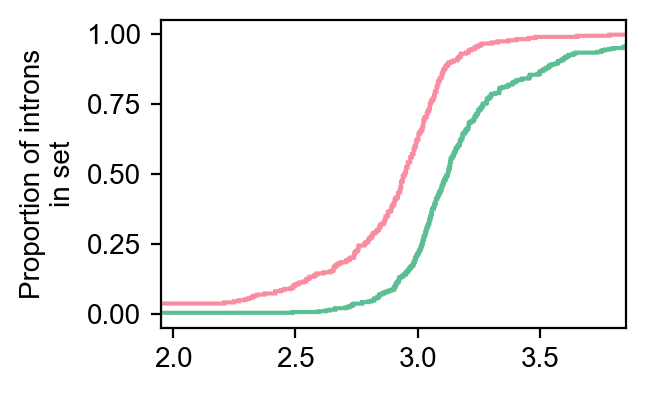

In [86]:

fig, ax = plt.subplots(1, 1, figsize=(3,2))

intlists = [green_bcs,
            red_bcs]
cols = [nicecolors(2),nicecolors(0)]
labels = ['top green introns','top red introns']
legend_elements=[]

set_medians = []

for i,intlist in enumerate(intlists):
    bcs_mask = np.array([b in intlist for b in RNA_seq_bcs])
    ax.hist(norm_l2fc[bcs_mask],bins=2000,
             color=cols[i], cumulative=True, histtype='step', density=True, 
             linewidth=1.5, alpha=0.8, linestyle='-', label=labels[i])
    legend_elements.append(Line2D([0],[0],
                                  color=cols[i],
                                  label=labels[i],
                                 linewidth=2))
    set_medians.append(np.median(norm_l2fc[bcs_mask]))


ax.plot([set_medians[1],0.5],
        [set_medians[0],0.5],
        color='black', linestyle='-', linewidth=1.5)

ax.set_ylabel('Proportion of introns\nin set')
#ax.set_xlim(np.median(norm_l2fc)-cdf_range,np.median(norm_l2fc)+cdf_range)
ax.set_xlim(1.95,3.85)
ax.set_ylim(-0.05,1.05)
#ax.set_xlabel(f'log2 IME for\ndifferent sets of introns from iFACS')
#plt.legend(handles=legend_elements, #loc='upper left'
#           bbox_to_anchor=(0.7,1.4)
#          )

plt.savefig('figures/Fig6C.png', dpi=900, bbox_inches='tight')

plt.show()

In [87]:
set_medians[0]-set_medians[1]

0.1741629179940336

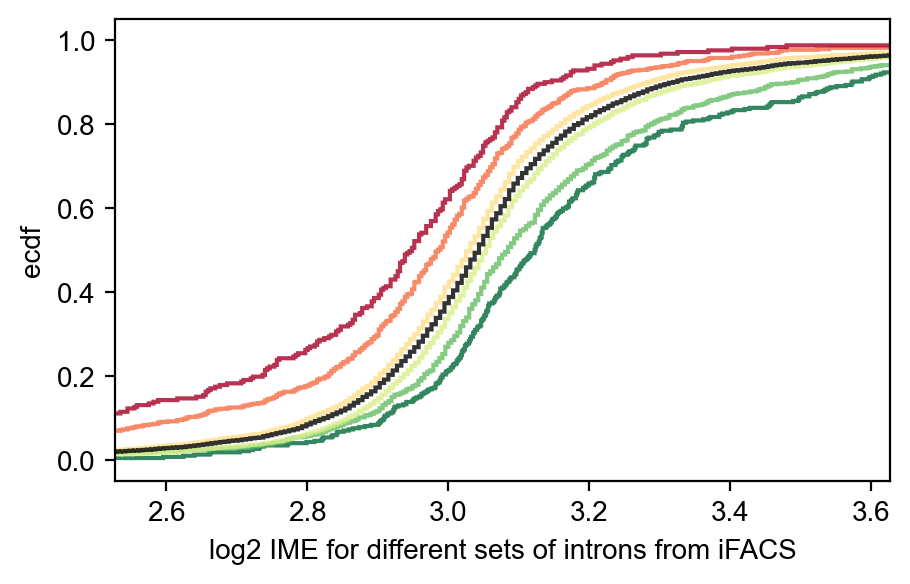

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

intlists = [green_bcs,
            all_stages_either_rep_green,
            any_green,
            any_red,
            all_stages_either_rep_red,
            red_bcs]

for i,intlist in enumerate(intlists):
    plot_cdf(ax, intlist, cmap(i))
#plot_cdf(ax, round1, 'purple')
#plot_cdf(ax, bg_set, 'blue')
plot_cdf(ax, all_FACS_bcs, 'k')

ax.set_xlabel(f'log2 IME for different sets of introns from iFACS')
plt.show()

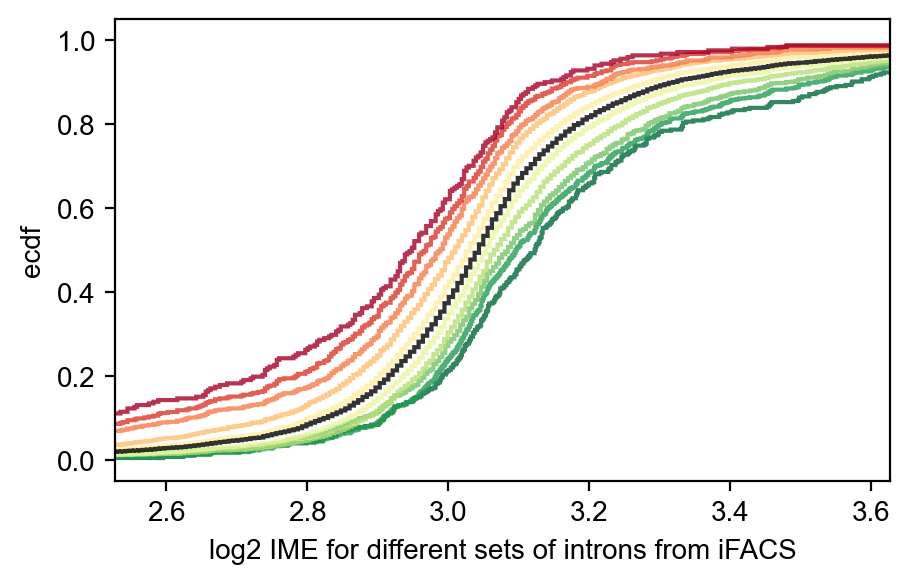

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))

cmap = plt.get_cmap('RdYlGn_r', 10)

intlists = [green_bcs,
            top2_green_clean,
            both_top2_green,
            any_top2_green,
            any_green,
            
            any_red,
            any_top2_red, 
            both_top2_red,
            top2_red_clean,
            red_bcs]

for i,intlist in enumerate(intlists):
    plot_cdf(ax, intlist, cmap(i))
#plot_cdf(ax, round1, 'purple')
#plot_cdf(ax, bg_set, 'blue')
plot_cdf(ax, all_FACS_bcs, 'k')

ax.set_xlabel(f'log2 IME for different sets of introns from iFACS')
plt.show()

In [90]:
len(top2_green_clean)

1244

In [91]:
RNA_vs_FACS = {l:i for l,i in zip(['green_bcs','red_bcs'],
                                  [green_bcs,red_bcs])}
RNA_vs_FACS['RNA_up'] = set(up_bcs)
RNA_vs_FACS['RNA_down'] = set(down_bcs)

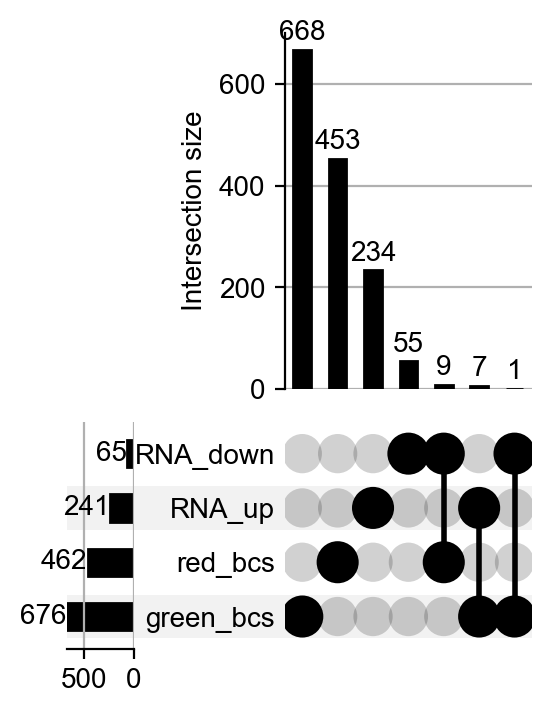

In [92]:
fig = plt.figure(figsize=(3,4))
ups.plot(ups.from_contents(RNA_vs_FACS), 
         fig=fig,
         element_size=None,
         sort_by='cardinality',
         min_subset_size=1, 
         show_counts=True)
plt.show()

In [93]:
[(i,b2i[i]) for i in RNA_vs_FACS['RNA_down'] if i in RNA_vs_FACS['green_bcs']]

[('CATATCCTCAAACCTTTT',
  'gtgagtagcgggCCCCTACGTCATGTAGCTTACCTACTCAGATTGAGTAATTCTACCTCATTTATCTAGGCTGGTAAACTAGGTATTCCGAAGAATCGTAACCGTTTATGTACAATAGTCGGTACGTCCCAAGGGCTCGCTATGTGCCAGGGACAGCAAGGGTAGACGGGGGgcctcagacagtggttcaaagtttttttcttccatttcag')]

In [94]:
RNA_vs_FACS.keys()

dict_keys(['green_bcs', 'red_bcs', 'RNA_up', 'RNA_down'])

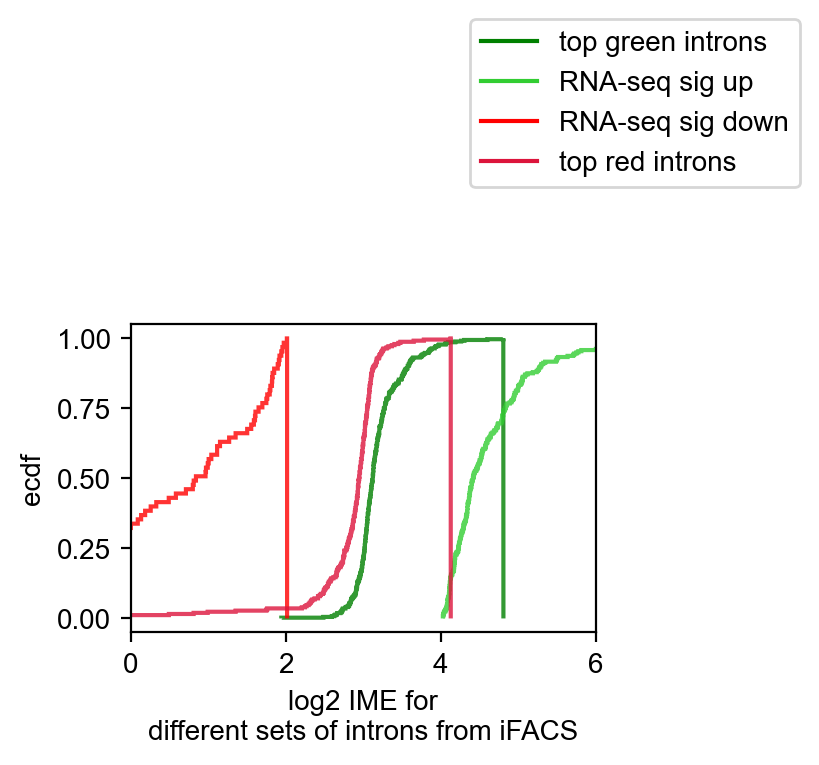

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(3,2))

intlists = [green_bcs,
            RNA_vs_FACS['RNA_up'],
            RNA_vs_FACS['RNA_down'],
            red_bcs]
cols = ['green','limegreen','red','crimson']
labels = ['top green introns','RNA-seq sig up', 'RNA-seq sig down', 'top red introns']
legend_elements=[]

for i,intlist in enumerate(intlists):
    bcs_mask = np.array([b in intlist for b in RNA_seq_bcs])
    ax.hist(norm_l2fc[bcs_mask],bins=2000,
             color=cols[i], cumulative=True, histtype='step', density=True, 
             linewidth=1.5, alpha=0.8, linestyle='-', label=labels[i])
    legend_elements.append(Line2D([0],[0],
                                  color=cols[i],
                                  label=labels[i]))
ax.set_ylabel('ecdf')
#ax.set_xlim(np.median(norm_l2fc)-cdf_range,np.median(norm_l2fc)+cdf_range)
ax.set_xlim(0,6)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel(f'log2 IME for\ndifferent sets of introns from iFACS')
plt.legend(handles=legend_elements, #loc='upper left'
           bbox_to_anchor=(0.7,1.4)
          )
plt.show()


cutoff of at least 1 total reads per intron:



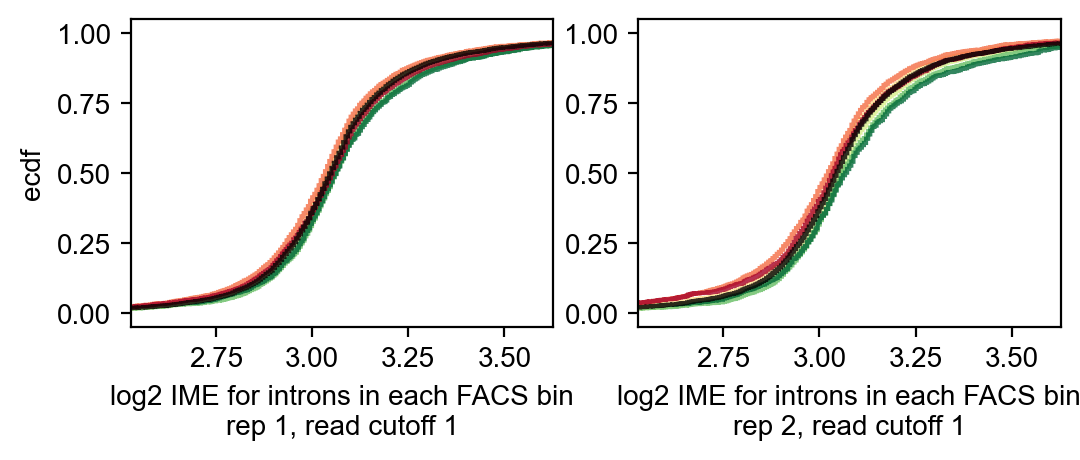


cutoff of at least 10 total reads per intron:



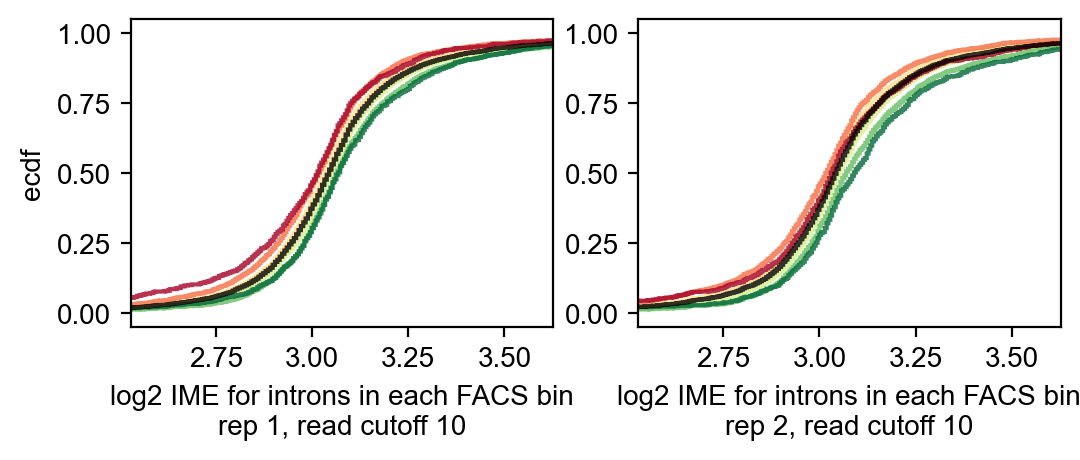


cutoff of at least 100 total reads per intron:



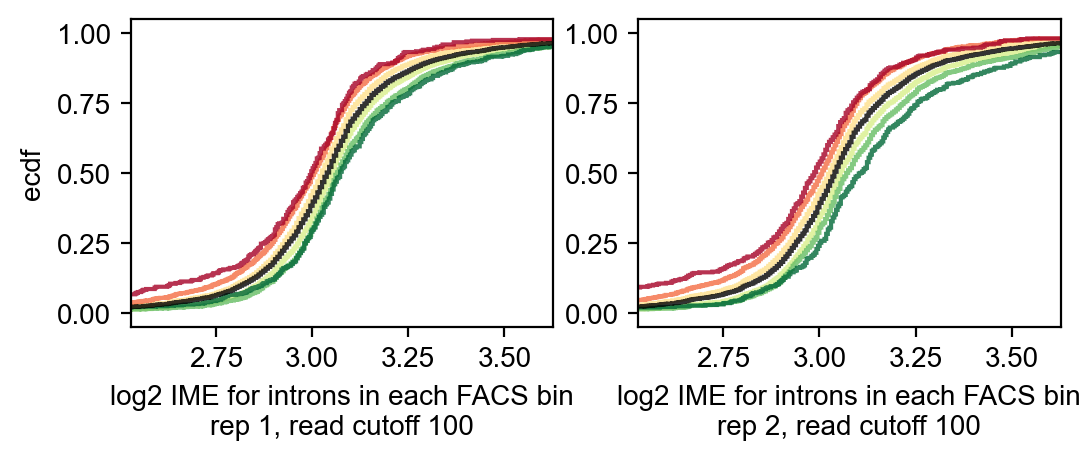


cutoff of at least 1000 total reads per intron:



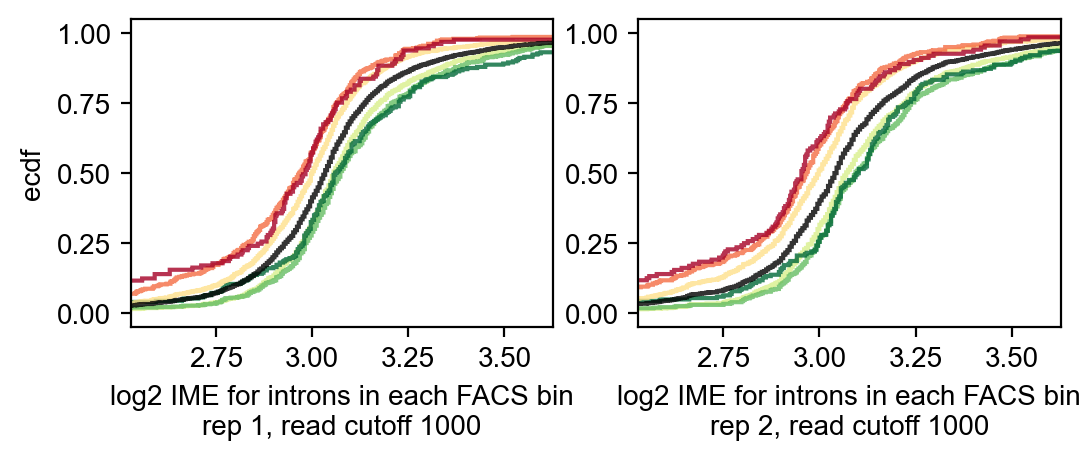

In [96]:
def plot_all_iFACS_bins_cdf(ax,rep,intsets,flip=False):
    cmap = plt.get_cmap('RdYlGn_r', 6)
    names = [x+'_'+str(rep) for x in iFACS_bins]
    all_ints_in_rep = set()
    for i in [2,1,0,3,4,5]:
        ints_in_set = intsets[names[i]]
        plot_cdf(ax, ints_in_set, cmap(i), ylabel='')
        all_ints_in_rep = all_ints_in_rep.union(ints_in_set)
    plot_cdf(ax, all_ints_in_rep, 'black', ylabel='')

for n in [1,10,100,1000]:
    print(f'\ncutoff of at least {n} total reads per intron:\n')
    fig, axs = plt.subplots(1, 2, figsize=(6, 2))
    for r in [0,1]:
        plot_all_iFACS_bins_cdf(axs[r],rep=(r+1),intsets=intsets_with_n_reads[n])
        axs[r].set_xlabel(f'log2 IME for introns in each FACS bin\nrep {r+1}, read cutoff {n}')
        axs[r].set_xlim(np.median(norm_l2fc)-cdf_range,np.median(norm_l2fc)+cdf_range)
        axs[r].set_ylim(-0.05,1.05)
        if r==0:
            axs[r].set_ylabel('ecdf')
    plt.show()